In [1]:
import pandas as pd
import datajoint as dj
dj.config['database.host'] = '10.86.1.219'
dj.config['database.user'] = 'root'
dj.config['database.password'] = 'retina'
dj.config["enable_python_native_blobs"] = True # Only for testing in dj0.12 (https://github.com/datajoint/datajoint-python#python-native-blobs)

%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE

import main
import seaborn as sns
drive_path = r"\\NERFHF01/djnerf1/VEIDB/"
# data_path = r"Y:\Data"
data_path =r"W:\Data/"
ft = main.load(drive_path, data_path)

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@10.86.1.219:3306


In [2]:
from datetime import date
import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
import os
import seaborn as sb
sb.set_style('dark')

In [3]:
exp_table = ft.Experiment()
sess_table = ft.Session()
mouse_table = ft.Mouse()
subsess_table = ft.Subsession()
raw_table = ft.ephys_tables.EphysRaw()
raw_table_helper = ft.ephys_tables.EphysRawHelper()
subsess_events_table = ft.event_tables.SubsessionEvents()
subsess_spikes_table = ft.ephys_tables.SubsessionSpikes()
trial_events_table = ft.event_tables.TrialEvents()

sorted_table = ft.ephys_tables.SpikeSorted()

In [4]:
def smooth_spikecounts(spikecounts, sigma=2):
    return ndimage.gaussian_filter1d(spikecounts, sigma)

def filter_clusters(clusters, cluster_annot, annot=['good']):
    clusters_filtered = {}
    for c in cluster_annot:
        if cluster_annot[c] in annot:
            clusters_filtered[c] = clusters.get(c)
    return clusters_filtered
                

def plot_spike_raster(clusters, start, end, ax, event_times=None, colored=False, color_palette=None, visualize_depth=False, cluster_depths=None):
    data = []

    for c, cl_spike_times in clusters.items():
        if cl_spike_times is not None and isinstance(cl_spike_times, np.ndarray):
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            data.append((c, cl_spike_times_sub))
            
    for i, (cluster, cl_spike_times) in enumerate(data[:]):
        if visualize_depth:
            depth = cluster_depths[cluster]
        else:
            depth = cluster
            
        if colored:
            color = color_palette[random.randint(0, len(color_palette)-1)]
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[color]) # SCATTER PLOT
        else:
            ax.scatter(np.array(cl_spike_times)/30000, np.ones_like(cl_spike_times)*depth, marker='|', c=[(0, 0, 0, 0.4)]) # SCATTER PLOT
    
    ax.set_ylabel('depth')
    ax.set_xlabel('time (s)')
    if event_times is not None:
        event_types_and_times = list(zip(*[(i, t) for tup in event_times for (i, t) in enumerate(tup)]))
        event_types = np.array(event_types_and_times[0]) 
        event_times = np.array(event_types_and_times[1])
        event_times_sub = event_times[(event_times >= start) & (event_times < end)]
        event_types_sub = event_types[(event_times >= start) & (event_times < end)]
        for event in event_times_sub:
            ax.axvline(event/30000, ymin=0, ymax=1, c='r', alpha=0.8)
            
def spikes_2_spikecounts(clusters, start, end, binsize=30):
    """Excludes neurons that don't fire"""
    first_spike_time = min([s[0] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    last_spike_time = max([s[-1] for s in clusters.values() if isinstance(s, np.ndarray) and len(s)>0], default=0)    
    fr_clusters = {}
    for i, (c, cl_spike_times) in enumerate(clusters.items()):
        if cl_spike_times is not None:
            cl_spike_times_sub = cl_spike_times[(cl_spike_times >= start) & (cl_spike_times < end)]
            fr, _ = np.histogram(cl_spike_times_sub, bins=np.arange(start, end, (30000/1000)*binsize))
            fr_clusters[c] = np.float32(fr)
    return fr_clusters

def plot_spikecounts_mean(fr_clusters, ax, mean=True, event_times=None):
    trial_frs = []
    for j, (c, firing_rate) in enumerate(fr_clusters.items()):
#         axs[i].plot(np.ones_like(firing_rate)*c*1, firing_rate)
        trial_frs.append(firing_rate)
    ax.plot(np.mean(np.array(trial_frs), axis=0))


In [10]:
def get_spiking_tensor(session_key, stim, before=int(30000*0.1), after=0):    
    subsess_key = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
    cluster_info, clusters = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']
    
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    trial_lengths = [e-s for s, e in zip(trial_starts, trial_ends)]
    print("Trial lengths: ", trial_lengths)

    n_trials, n_neurons, window_size = len(trial_starts), len(clusters_good), int(max(trial_lengths)+before+after)  
    spiking_tensor = np.zeros(shape=(n_trials, n_neurons, window_size))
    spiking_tensor_meta = np.zeros(shape=(n_neurons))
    for trial_idx, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        for c_idx, c in enumerate(clusters_good):
            c_activity = clusters.get(c, None)
            if c_activity is not None:
                spiking_activity = c_activity[(c_activity >= start-before) & (c_activity < end+after)] - start - before
#                 print(spiking_activity)
                spiking_tensor[trial_idx, c_idx, spiking_activity] = 1
            spiking_tensor_meta[c_idx] = c
    
    return spiking_tensor, spiking_tensor_meta

def get_fr_tensor(subsess_key, before=int(30000*0.1), after=0, binsize=25):    
    cluster_info, clusters = (subsess_spikes_table & subsess_key).fetch1('cluster_info', 'clusters')
    clusters_good = [c for c, annot in cluster_info['group'].items() if annot == 'good']
    
    trial_starts, trial_ends = (subsess_events_table & subsess_key).fetch1('trials_starts', 'trials_ends')
    trial_lengths = [e-s for s, e in zip(trial_starts, trial_ends)]
    print("Trial lengths: ", trial_lengths)

    n_trials, n_neurons, window_size = len(trial_starts), len(clusters_good), int(max(trial_lengths)+before+after)  
    n_bins = int((window_size*1000)/(30000*binsize))
    fr_tensor = np.zeros(shape=(n_trials, n_neurons, n_bins))
    fr_tensor_meta = np.zeros(shape=(n_neurons))
    for trial_idx, (start, end) in enumerate(zip(trial_starts, trial_ends)):
        for c_idx, c in enumerate(clusters_good):
            c_activity = clusters.get(c, None)
            if c_activity is not None:
                spiking_activity = c_activity[(c_activity >= start-before) & (c_activity < end+after)]
                fr, _ = np.histogram(spiking_activity, bins=np.arange(start-before, end+after, (30000/1000)*binsize))
#                 print(fr)
                fr_tensor[trial_idx, c_idx, :len(fr)] = smooth_spikecounts(fr, sigma=0.5)
            fr_tensor_meta[c_idx] = c
    
    return fr_tensor, fr_tensor_meta


# Neural decoding
The purpose of this notebook is twofold:
1. How well can a threat (looming) vs non-threat (dimming) stimulus, and a variety of stimulus parameters, be decoded based on the population activity of spike sorted neurons versus unsorted activity?
2. What are the dynamics of this decoding for both stimuli? Use encoding axes as seen in Alexandra Libby's paper.

These points are investigated on a trial-by-trial basis.

In [11]:
# sessions = [{'experiment_id': '01230', 'session_id': '20200326a'}, {'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}]
sessions = [{'experiment_id': '01231', 'session_id': '20200327a'}, {'experiment_id': '01232', 'session_id': '20200328a'}, {'experiment_id': '01261', 'session_id': '20200327f'}]
sessions_sSC_depths = [(1800, 2250), (2000, 2450), (2150, 2550)]

In [12]:
figures_folder = os.path.join(r"C:\Users\bramn\Documents\Projects\DatajointVEIDB\images\clustering")
if not os.path.isdir(figures_folder):
    os.mkdir(figures_folder)
    
stims_vis = ['EXPA', 'DIMM', 'CHPE']

In [106]:
def load_session(session_key):
    print(session_key)
    stims_dict = {}
    for stim in stims_vis:
        stims_dict[stim] = {}
        subsess_key = session_key
        subsess_key['subsession_type'] = stim
        fr_tensor, fr_tensor_meta = get_fr_tensor(subsess_key, binsize=30, before=int(30000*0), after=int(30000*0))
        subsess_key = {'subsession_type': stim, 'experiment_id': session_key['experiment_id'], 'session_id': session_key['session_id']}
        stims_dict[stim]['key'] = subsess_key
        stims_dict[stim]['fr_tensor'] = fr_tensor
        stims_dict[stim]['fr_tensor_meta'] = fr_tensor_meta
    return stims_dict
        
sessions_list = []
for sess in sessions:
    sessions_list.append(load_session(sess))

# padding = 0
# binsize = 25
# smooth_sigma = 1
# n_trials = 4 

# spiking_tensor, spiking_tensor_meta = get_spiking_tensor(sessions[0], 'EXPA')
# fr_tensor, fr_tensor_meta = get_fr_tensor(sessions[0], 'DIMM')

{'experiment_id': '01231', 'session_id': '20200327a', 'subsession_type': 'CHPE'}
Trial lengths:  [24999, 24995, 25000, 24995, 25001, 25001, 25000, 25001, 25000, 24999]
Trial lengths:  [24996, 25000, 25000, 25007, 25002, 25000, 25000, 25000, 24995, 25000]
Trial lengths:  [962490, 962502, 962494, 962494, 962494, 962495, 962495, 962496, 962500, 962491]
{'experiment_id': '01232', 'session_id': '20200328a', 'subsession_type': 'CHPE'}
Trial lengths:  [25000, 24988, 25000, 25000, 24998, 25008, 25000, 25000, 25001, 25002]
Trial lengths:  [25001, 25001, 24999, 25002, 25007, 24996, 25001, 25000, 25001, 25000]
Trial lengths:  [962496, 962496, 962496, 962496, 962495, 962495, 962495, 962494, 962494, 962494]
{'experiment_id': '01261', 'session_id': '20200327f', 'subsession_type': 'CHPE'}
Trial lengths:  [24999, 24999, 25001, 25001, 25000, 25001, 25001, 25000, 25000, 25004]
Trial lengths:  [25002, 25001, 24994, 24996, 25001, 24999, 25000, 25000, 24998, 25000]
Trial lengths:  [962498, 962495, 962495, 

In [107]:
EXPA_fr_list = []
DIMM_fr_list = []
CHPE_fr_list = []
relat_depth_list = []
for sess, (sSC_begin, sSC_end) in zip(sessions_list, sessions_sSC_depths):
    cluster_info = (sorted_table & sess['EXPA']['key']).fetch1('cluster_info')
    
    """ Might contain a bug!! Check!"""
    cluster_depths = np.array(list(map(lambda x: cluster_info['depth'][x], sess['EXPA']['fr_tensor_meta'])))
    sorted_idxs = np.argsort(cluster_depths)
    sSC_filter = ((cluster_depths >= sSC_begin) & (cluster_depths <= sSC_end))[sorted_idxs]
    sSC_idxs = sorted_idxs[sSC_filter]
    
    EXPA_fr_list.append(sess['EXPA']['fr_tensor'][:,sSC_idxs,:])
    DIMM_fr_list.append(sess['DIMM']['fr_tensor'][:,sSC_idxs,:])
    CHPE_fr_list.append(sess['CHPE']['fr_tensor'][:,sSC_idxs,:])
    relat_depth_list.append(cluster_depths[sSC_idxs]-sSC_begin)
    
# EXPA_fr = np.concatenate([sess['EXPA']['fr_tensor'] for sess in sessions_list], axis=1)
# DIMM_fr = np.concatenate([sess['DIMM']['fr_tensor'] for sess in sessions_list], axis=1)
# CHPE_fr = np.concatenate([sess['CHPE']['fr_tensor'] for sess in sessions_list], axis=1)
EXPA_fr = np.concatenate(EXPA_fr_list, axis=1)
DIMM_fr = np.concatenate(DIMM_fr_list, axis=1)
CHPE_fr = np.concatenate(CHPE_fr_list, axis=1)
relat_depth = np.concatenate(relat_depth_list)

In [108]:
relat_depth_sorted_idxs = np.argsort(relat_depth)
EXPA_fr = EXPA_fr[:,relat_depth_sorted_idxs]
DIMM_fr = DIMM_fr[:,relat_depth_sorted_idxs]
CHPE_fr = CHPE_fr[:,relat_depth_sorted_idxs]

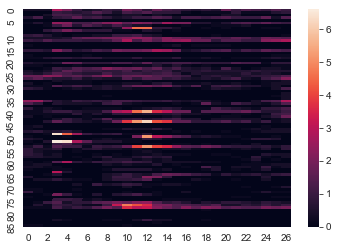

In [109]:
sb.heatmap(np.mean(EXPA_fr[:5], axis=0))

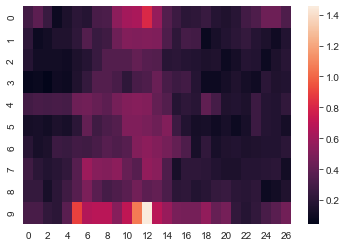

In [110]:
sb.heatmap(np.mean(DIMM_fr, axis=1))

In [111]:
from sklearn import svm

In [112]:
len(EXPA_fr_list)

3

### For each time point
First I take only two categories: looming and dimming. Next, add the 'no stimulus' category. Also try with standrads scaler!

In [155]:
""" data structure """
# EXPA_swap, DIMM_swap = np.swapaxes(EXPA_fr, 0, 1), np.swapaxes(DIMM_fr, 0, 1)
exp_idx = 1
EXPA_swap, DIMM_swap = np.swapaxes(EXPA_fr_list[exp_idx], 0, 1), np.swapaxes(DIMM_fr_list[exp_idx], 0, 1)

EXPA_all_timepoints = np.reshape(EXPA_swap, newshape=(EXPA_swap.shape[0], EXPA_swap.shape[1]*EXPA_swap.shape[2]))
DIMM_all_timepoints = np.reshape(DIMM_swap, newshape=(DIMM_swap.shape[0], DIMM_swap.shape[1]*DIMM_swap.shape[2]))

X = np.concatenate([EXPA_all_timepoints, DIMM_all_timepoints], axis=1).T
y = np.concatenate([np.zeros(shape=EXPA_all_timepoints.shape[1]), np.ones(shape=DIMM_all_timepoints.shape[1])])

In [156]:
clf = svm.SVC(kernel='linear', C=0.01)

In [157]:
# Add cross validation !!!
clf.fit(X, y)

SVC(C=0.01, kernel='linear')

In [158]:
clf.score(X, y)

0.7518518518518519

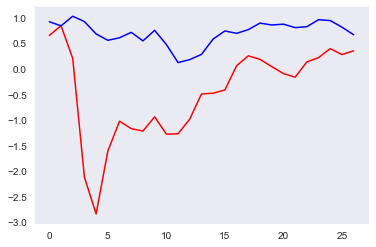

In [159]:
# Also try for individual trials instead of taking the mean, and try z-scoring the signals!!
# EXPA_fr_mean = np.mean(EXPA_fr, axis=0)
# DIMM_fr_mean = np.mean(DIMM_fr, axis=0)
EXPA_fr_mean = np.mean(EXPA_fr_list[exp_idx], axis=0)
DIMM_fr_mean = np.mean(DIMM_fr_list[exp_idx], axis=0)

fig, axs = plt.subplots(1, 1)
axs.plot(clf.decision_function(EXPA_fr_mean.T), 'r')
axs.plot(clf.decision_function(DIMM_fr_mean.T), 'b')
# axs[0].plot(clf.decision_function(EXPA_fr_mean.T))
# axs[1].plot(clf.decision_function(DIMM_fr_mean.T))
plt.show()

In [128]:
EXPA_fr_mean = np.mean(EXPA_fr, axis=0)
EXPA_dec_func = clf.decision_function(EXPA_fr_mean.T)

plt.plot(EXPA_dec_func)
plt.show()

ValueError: X.shape[1] = 86 should be equal to 29, the number of features at training time

In [167]:
EXPA_fr_mean = np.mean(EXPA_fr, axis=(0, 2))
DIMM_fr_mean = np.mean(DIMM_fr, axis=(0, 2))


In [168]:
EXPA_fr_mean.shape

(86,)

In [171]:
np.arccos((EXPA_fr_mean.T @ DIMM_fr_mean)/(np.linalg.norm(EXPA_fr_mean)*np.linalg.norm(DIMM_fr_mean)))

0.4256953982586482

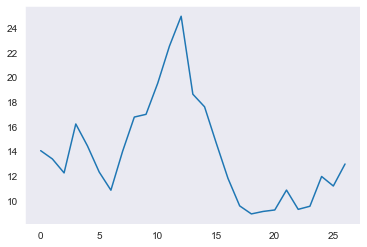

In [166]:
plt.plot((EXPA_fr_mean.T @ DIMM_fr_mean)[:,0])
plt.show()

### For average activity during the stimulus